# Simulation Engine of Flu Spread in Germany
- Models number of infected people with a SIR model on a weekly basis
- Splits into 64 groups: 16 states * (age > 60) * (high risk person)
- Base infection rate per group initialized at 10%
- At each time step, we can make a promotion for flu shots that increases the number of vaccinations per group and thereby decreases infection rate. A promotion has a unit price *unit_price_promotion* while the benefit of fewer infections is quantified by valuing a prevented sick day with 200EUR and assuming that a person is sick for 2 days on average. The reward is the sum of these two terms.

In [14]:
import numpy as np
import random
import gymnasium as gym

# TODO: change state and action space to state x risk_level x age_group -> Done
# TODO: initialize state space with data from Kai
# TODO: check how Amaan integrated the insights from exploratory into the LLM prompt
# TODO: integrate LLM based answers from Amaan


class InfluenzaInfectionEnv(gym.Env):
    """Custom Gym Environment for Influenza Spread Simulation"""
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(InfluenzaInfectionEnv, self).__init__()

        # Economic Parameters
        self.unit_price_promotion = 500_000
        self.loss_income_sick = 200

        # Population Data
        self.population = {'Baden-Württemberg_below_60_has_disease': 4677829,
                                'Baden-Württemberg_below_60_healthy': 3197303,
                                'Baden-Württemberg_60_and_above_has_disease': 2004783,
                                'Baden-Württemberg_60_and_above_healthy': 1370273,
                                'Bavaria_below_60_has_disease': 5505271,
                                'Bavaria_below_60_healthy': 3762861,
                                'Bavaria_60_and_above_has_disease': 2359401,
                                'Bavaria_60_and_above_healthy': 1612655,
                                'Berlin_below_60_has_disease': 1567356,
                                'Berlin_below_60_healthy': 1071290,
                                'Berlin_60_and_above_has_disease': 671724,
                                'Berlin_60_and_above_healthy': 459124,
                                'Brandenburg_below_60_has_disease': 1052419,
                                'Brandenburg_below_60_healthy': 719330,
                                'Brandenburg_60_and_above_has_disease': 451036,
                                'Brandenburg_60_and_above_healthy': 308284,
                                'Bremen_below_60_has_disease': 282798,
                                'Bremen_below_60_healthy': 193292,
                                'Bremen_60_and_above_has_disease': 121199,
                                'Bremen_60_and_above_healthy': 82839,
                                'Hamburg_below_60_has_disease': 789670,
                                'Hamburg_below_60_healthy': 539741,
                                'Hamburg_60_and_above_has_disease': 338430,
                                'Hamburg_60_and_above_healthy': 231317,
                                'Hesse_below_60_has_disease': 2616693,
                                'Hesse_below_60_healthy': 1788514,
                                'Hesse_60_and_above_has_disease': 1121440,
                                'Hesse_60_and_above_healthy': 766506,
                                'Lower Saxony_below_60_has_disease': 3337917,
                                'Lower Saxony_below_60_healthy': 2281472,
                                'Lower Saxony_60_and_above_has_disease': 1430536,
                                'Lower Saxony_60_and_above_healthy': 977773,
                                'Mecklenburg-Western Pomerania_below_60_has_disease': 660700,
                                'Mecklenburg-Western Pomerania_below_60_healthy': 451590,
                                'Mecklenburg-Western Pomerania_60_and_above_has_disease': 283157,
                                'Mecklenburg-Western Pomerania_60_and_above_healthy': 193538,
                                'North Rhine-Westphalia_below_60_has_disease': 7453452,
                                'North Rhine-Westphalia_below_60_healthy': 5094446,
                                'North Rhine-Westphalia_60_and_above_has_disease': 3194336,
                                'North Rhine-Westphalia_60_and_above_healthy': 2183334,
                                'Rhineland-Palatinate_below_60_has_disease': 1702244,
                                'Rhineland-Palatinate_below_60_healthy': 1163487,
                                'Rhineland-Palatinate_60_and_above_has_disease': 729533,
                                'Rhineland-Palatinate_60_and_above_healthy': 498637,
                                'Saarland_below_60_has_disease': 408460,
                                'Saarland_below_60_healthy': 279183,
                                'Saarland_60_and_above_has_disease': 175054,
                                'Saarland_60_and_above_healthy': 119649,
                                'Saxony_below_60_has_disease': 1679105,
                                'Saxony_below_60_healthy': 1147671,
                                'Saxony_60_and_above_has_disease': 719616,
                                'Saxony_60_and_above_healthy': 491859,
                                'Saxony-Anhalt_below_60_has_disease': 893024,
                                'Saxony-Anhalt_below_60_healthy': 610384,
                                'Saxony-Anhalt_60_and_above_has_disease': 382724,
                                'Saxony-Anhalt_60_and_above_healthy': 261593,
                                'Schleswig-Holstein_below_60_has_disease': 1210341,
                                'Schleswig-Holstein_below_60_healthy': 827270,
                                'Schleswig-Holstein_60_and_above_has_disease': 518717,
                                'Schleswig-Holstein_60_and_above_healthy': 354544,
                                'Thuringia_below_60_has_disease': 876586,
                                'Thuringia_below_60_healthy': 599148,
                                'Thuringia_60_and_above_has_disease': 375679,
                                'Thuringia_60_and_above_healthy': 256777}
        
        self.states = list(self.population.keys())
        self.state_space_dim = len(self.states)

        # Gym Spaces
        self.action_space = gym.spaces.MultiBinary(self.state_space_dim)  # Actions correspond to the 16 states
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(self.state_space_dim,), dtype=np.uint8)

        # Disease Parameters
        self.num_days_sick = 1.5
        self.n_step = 0
        self.max_steps = 28
        self.base_infection_rate = np.full(self.state_space_dim, 0.09)
        self.recovery_rate = 0.1
    
        self.intervention_effect = 0.01

        # Initialize SIR Model
        self.reset()

    def reset(self):
        """Resets the environment and returns the initial observation."""
        # Initialize S, I, R for each state
        self.S = {state: self.population[state] for state in self.states}
        self.I = {state: 0 for state in self.states}
        self.R = {state: 0 for state in self.states}

        for state in self.states:
            initial_infected = int(0.05 * self.S[state])
            self.I[state] = initial_infected
            self.S[state] -= initial_infected

        self.n_step = 0
        return self._get_observation()


    def step(self, action: np.ndarray):
        """
        Takes an action and updates the environment state.
        :param action: NumPy array of length 16 indicating intervention in each state.
        :return: Tuple (observation, reward, done, info)
        """
        self.n_step += 1
        done = self.n_step >= self.max_steps

        # Convert dictionaries to NumPy arrays for vectorized computation
        S_arr = np.array(list(self.S.values()))
        I_arr = np.array(list(self.I.values()))
        R_arr = np.array(list(self.R.values()))
        population_arr = np.array(list(self.population.values()))

        # Compute new infections and recoveries
        infection_rate = self.base_infection_rate - action*self.intervention_effect
        new_infections = (infection_rate * I_arr * S_arr) / population_arr
        new_infections = np.minimum(new_infections, S_arr).astype(int)
        recoveries = (self.recovery_rate * I_arr).astype(int)

        # Compute reward
        self.n_infections_prevented_per_group = action*self.intervention_effect*I_arr*S_arr/ population_arr
        self.n_infections_pervented_per_state = self.n_infections_prevented_per_group.reshape(-1, 4).sum(axis=1)
        economic_gain_state = self.n_infections_pervented_per_state * self.loss_income_sick * self.num_days_sick
        promotion_cost_state = np.sum(action.reshape(-1, 4).sum(axis=1) * self.unit_price_promotion)
        self.reward_state = economic_gain_state - promotion_cost_state
        reward = self.reward_state.sum()

        # Update state
        S_arr -= new_infections
        I_arr += new_infections - recoveries
        R_arr += recoveries

        # Convert back to dictionary for readability
        self.S = dict(zip(self.states, S_arr))
        self.I = dict(zip(self.states, I_arr))
        self.R = dict(zip(self.states, R_arr))

        return self._get_observation(), reward, done, {}

    def _get_observation(self) -> dict:
        """Returns the current state as an observation."""
        return {'S': self.S, 'I': self.I, 'R': self.R}

# Example Usage
if __name__ == "__main__":
    infection_env = InfluenzaInfectionEnv()
    observation = infection_env.reset()
    action = np.ones(infection_env.state_space_dim)
    observation, reward, done, info = infection_env.step(action)


## Example Simulation

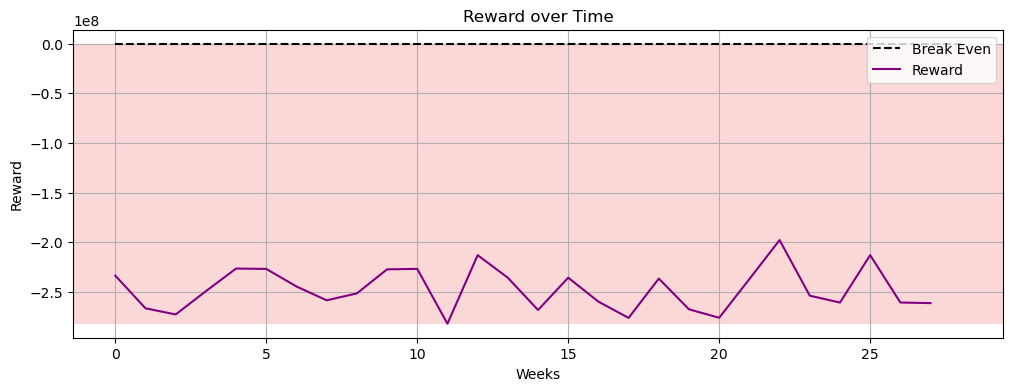

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize environment
infection_env = InfluenzaInfectionEnv()
infection_env.reset()

# Simulation parameters
num_weeks = infection_env.max_steps
history = {
    "Weeks": [],
    "Susceptible": [],
    "Infected": [],
    "Recovered": [],
    "Reward": [],
    "rewards_state": [],
    "n_infections_prevented_state": []
}

# Reset environment
observation = infection_env.reset()

for week in range(num_weeks):
    # Generate a random intervention action (either 0 or 1 for each state)
    action = np.random.randint(0, 2, 16*2*2)

    # Take a step in the environment
    observation, reward, done, _ = infection_env.step(action)
    

    # Aggregate data
    total_S = sum(observation["S"].values())
    total_I = sum(observation["I"].values())
    total_R = sum(observation["R"].values())

    # Store history
    history["Weeks"].append(week)
    history["Susceptible"].append(total_S)
    history["Infected"].append(total_I)
    history["Recovered"].append(total_R)
    history["Reward"].append(reward)
    history["rewards_state"].append(infection_env.reward_state)
    history["n_infections_prevented_state"].append(infection_env.n_infections_pervented_per_state)


    if done:
        break

# Plot rewards over time
plt.figure(figsize=(12, 4))
plt.grid()
plt.hlines(0, 0, num_weeks, color="black", linestyle="--", label="Break Even")
plt.plot(history["Weeks"], history["Reward"], label="Reward", color="purple")
plt.xlabel("Weeks")
plt.ylabel("Reward")
plt.title("Reward over Time")
if max(history["Reward"]) > 0:
    plt.axhspan(0, max(history["Reward"]), facecolor="lightgreen", alpha=0.3)
if min(history["Reward"]) < 0:  
    plt.axhspan(min(history["Reward"]), 0, facecolor="lightcoral", alpha=0.3)

plt.legend()
plt.show()


# Data Output
- the dict *history* contains the recorded data of each run
- the key *n_infections_prevented* contains a list of length 28, one for each week of the simulation. Each entry is an array of shape (16,), containing the absolute number of people that are not sick because of the intervention per state, e.g. the number of prevented infections
- the key *reward_state* contains the reward of the deployed policy for each state, is of shape (16,)

In [12]:
history["n_infections_prevented"]

[array([3740.6823    , 1120.715025  ,  319.0671    ,  714.12537498,
          39.33997489,  256.376525  , 2092.461175  ,  679.4974    ,
         662.82517497, 3456.9365    , 1944.58452498,  409.77342497,
         886.94917499,  714.1152    ,  989.70104998,  121.96142497]),
 array([3094.20175253, 2842.95228071,  730.39348916,    0.        ,
         146.55053099,  265.4854092 ,  825.83441196,  455.64165071,
         513.59794658, 3360.46839923,  874.09081828,   55.75095655,
        1644.67151915,  534.24926088,  798.38528035,  527.05644599]),
 array([1448.04500364, 4311.9253752 ,  699.43696694,  673.90187074,
           0.        ,  349.20217413,  802.62012792, 3658.92264902,
         419.34808761, 2439.71224128,  553.19863356,  259.89962353,
         985.20052652,  795.66387735,  703.72928088,  786.02575913]),
 array([3465.46657744, 3473.28646019,  977.80525846,    0.        ,
         176.40041036,  252.05188504,  845.97451679, 2541.82704951,
         698.19173946, 7000.04916937,  830

In [16]:
history["rewards_state"]

[array([-13396851.99000111, -14127577.93500001, -14781917.89500096,
        -14935729.53000426, -15000000.        , -14951775.07500222,
        -14730968.50500035, -14059910.08500242, -14841500.02500166,
        -13818851.53500065, -14653474.07250181, -14943168.06000532,
        -14766371.0250063 , -14962724.75250485, -14926085.12250418,
        -14753121.36750955]),
 array([-16367287.03540489, -15678075.06371409, -16568886.45666181,
        -16956903.14706569, -16983056.2318831 , -16781812.21181412,
        -16643787.22273854, -16864556.02716582, -16908477.76217648,
        -16252278.31648621, -16430780.89710241, -16904222.91471688,
        -16672291.01010688, -16910255.99507998, -16928146.37552075,
        -16743058.7628007 ]),
 array([-16592045.10282123, -16021703.46898971, -17346088.53463608,
        -17359492.0788735 , -17488644.91580053, -17241983.72469043,
        -17104644.25143898, -16540365.65755055, -17473465.48601308,
        -15489257.74541375, -17500000.        , -1743841